In [2]:
!pip install tensorflow_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 90.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

Preprocessing Data

In [9]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2220,spam,You have WON a guaranteed £1000 cash or a £200...,1
123,spam,Todays Voda numbers ending 7548 are selected t...,1
2876,ham,"Idk. You keep saying that you're not, but sinc...",0
4901,spam,"ou are guaranteed the latest Nokia Phone, a 40...",1
463,spam,"UpgrdCentre Orange customer, you may now claim...",1


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [14]:
X_train.head(4)

1809    Aiyo a bit pai seh ü noe... Scared he dun rem ...
591     For ur chance to win a £250 wkly shopping spre...
4643    You are being ripped off! Get your mobile cont...
3763    FREE for 1st week! No1 Nokia tone 4 ur mob eve...
Name: Message, dtype: object

BERT

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [17]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [21]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 24s 334ms/step - loss: 0.6884 - accuracy: 0.5786 - precision: 0.5794 - recall: 0.5732
Epoch 2/10
35/35 [==============================] - 12s 332ms/step - loss: 0.5539 - accuracy: 0.7795 - precision: 0.7657 - recall: 0.8054
Epoch 3/10
35/35 [==============================] - 12s 356ms/step - loss: 0.4725 - accuracy: 0.8339 - precision: 0.8191 - recall: 0.8571
Epoch 4/10
35/35 [==============================] - 13s 379ms/step - loss: 0.4212 - accuracy: 0.8598 - precision: 0.8444 - recall: 0.8821
Epoch 5/10
35/35 [==============================] - 12s 336ms/step - loss: 0.3878 - accuracy: 0.8723 - precision: 0.8516 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 12s 339ms/step - loss: 0.3642 - accuracy: 0.8750 - precision: 0.8646 - recall: 0.8893
Epoch 7/10
35/35 [==============================] - 12s 344ms/step - loss: 0.3468 - accuracy: 0.8848 - precision: 0.8659 - recall: 0.9107
Epoch 8/10
35/35 [================

In [23]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 345ms/step - loss: 0.2919 - accuracy: 0.8957 - precision: 0.9353 - recall: 0.8503


[0.29193568229675293,
 0.8957219123840332,
 0.9352940917015076,
 0.8502673506736755]

In [22]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 327ms/step


In [24]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[176,  11],
       [ 28, 159]])

Text(50.722222222222214, 0.5, 'Truth')

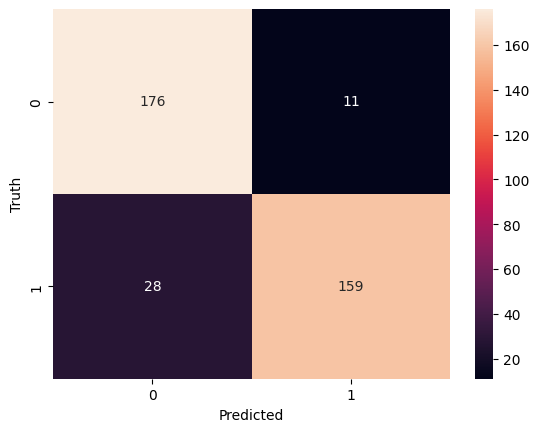

In [26]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')